In [2]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
file = '/data/predict/15F90ABFD1B13CE2/15F90ABFD1B13CE2_logs.json'

In [5]:
#sessions = {}
#with open(file, encoding='utf8') as f:
#    for line in tqdm(f):
#        data = json.loads(line)
#        if data['session_id'] not in sessions:
#            sessions[data['session_id']] = []
#        for prod_idx in data['viewed_products']:
#            try:
#                sessions[data['session_id']].append(prod_idx)
#            except ValueError: 
#                print('Sktrain_labelsiped ' + prod_idx)

In [6]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

1209561it [00:09, 130576.15it/s]


In [7]:
#sessions_lens = list(map(lambda x: len(x), sessions.values()))
users_lens = list(map(lambda x: len(x), users.values()))

In [8]:
#print(len(sessions.keys()))
print(len(users.keys()))

243384


In [9]:
#d = plt.hist(sessions_lens, bins=100, range=(3, 103))

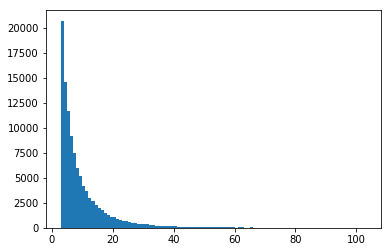

In [10]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [11]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [13]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [56]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))[-40:]
    if len(ids) > 1:
        if len(ids) not in users_with_product_idxs:
            users_with_product_idxs[len(ids)] = []
        users_with_product_idxs[len(ids)].append(ids)
    
#del users

In [65]:
max_batch_size = 32
test_size = 0.1
user_batches = []
user_valid_batches = []
for len_group in users_with_product_idxs.values():
    random.shuffle(len_group)
    for batch in chunks(len_group, max_batch_size):
        batch_data = np.array(list(map(lambda x: x[:-1], batch)))
        batch_labels = np.expand_dims(np.array(list(map(lambda x: x[1:], batch))), axis=2)
        if random.random() < test_size:
            user_valid_batches.append(
                (batch_data, batch_labels)
            )
        else:
            user_batches.append(
                (batch_data, batch_labels)
            )

In [66]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [67]:
#raw_data = []
#raw_abels  = []
#for products in tqdm(users_with_product_idxs):
#    if(len(products) > 1):
#        for i in range(len(products) - 6):
#            raw_data.append(np.array(products[:-1]))
#            raw_abels.append(np.array(products[-1]))

In [68]:
#data_np = np.stack(raw_data)
#labels_np = np.expand_dims(np.stack(raw_abels), axis=1)

In [69]:
#from sklearn.model_selection import train_test_split
#train_data, valid_data, train_labels, valid_labels  = train_test_split(data_np , labels_np, test_size=0.10, shuffle=True)

In [70]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.optimizers import Nadam


n_hidden = 200

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None)),
        BatchNormalization(),
        CuDNNGRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        CuDNNGRU(4*n_hidden,return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(n_hidden)),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [71]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer=Nadam())

In [73]:
model.fit_generator(
    generate_from_array(user_batches), 
    validation_data=generate_from_array(user_valid_batches), 
    steps_per_epoch=len(user_batches),
    validation_steps=len(user_valid_batches),
    epochs=4
)

Epoch 1/4
3521/3521 [==============================] - 44s 12ms/step - loss: 4.2104 - sparse_categorical_accuracy: 0.1728 - val_loss: 3.9163 - val_sparse_categorical_accuracy: 0.1887
Epoch 2/4
3521/3521 [==============================] - 42s 12ms/step - loss: 3.9731 - sparse_categorical_accuracy: 0.1907 - val_loss: 3.8539 - val_sparse_categorical_accuracy: 0.1990
Epoch 3/4
3521/3521 [==============================] - 42s 12ms/step - loss: 3.9178 - sparse_categorical_accuracy: 0.1952 - val_loss: 3.8307 - val_sparse_categorical_accuracy: 0.2020
Epoch 4/4
3521/3521 [==============================] - 40s 11ms/step - loss: 3.8830 - sparse_categorical_accuracy: 0.1984 - val_loss: 3.7794 - val_sparse_categorical_accuracy: 0.2066


In [ ]:
#model.fit(train_data, train_labels,validation_data=(valid_data,valid_labels), batch_size=256, epochs=4, shuffle=True)

In [81]:
model.save('/data/predict/15F90ABFD1B13CE2/15F90ABFD1B13CE2_predict_v3_dedup.h5')

In [82]:
model.save_weights('/data/predict/15F90ABFD1B13CE2/15F90ABFD1B13CE2_predict_weights_v3_1_dedup.h5')

In [83]:
import csv
with open('/data/predict/15F90ABFD1B13CE2/15F90ABFD1B13CE2_product_ids_3_dedup.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

## Eye ball validation

In [88]:
product_map = {}
with open('/data/predict/15F90ABFD1B13CE2/15F90ABFD1B13CE2_image_links.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        product_map[row[0]] = row[1]

In [246]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        return [product,product_map[list(product_idxs)[product]]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th><img src="' + product[1] + '" width="130"></th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            if pred in seen:
                next
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:1px solid red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td><img src="' + pred_data[1] + '" '+style+' width="130"></td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(random.choice(user_valid_batches)[0]))

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
